# It's the harvesting time for Spring Wheat! 
### The Canada Prairie Spring (CPS) class of wheat was established in 1985 and there are two sub-classes based on red and white kernel color: Canada Prairie Spring Red (CPSR) and Canada Prairie Spring White (CPSW). 
#### Source: https://www.saskatchewan.ca/business/agriculture-natural-resources-and-industry/agribusiness-farmers-and-ranchers/crops-and-irrigation/field-crops/cereals-barley-wheat-oats-triticale/wheat-canada-prairie-spring-wheat)

## Soft wheat offers various options for addressing allergies and food intolerance. I'm particularly interested in CPSW, but it's also important to consider the yield.

# Objective:
###  Can we provide some insights into patterns and grouping within "spring wheat" yield data?
####  Find the groups of spring wheat yield across Saskatchewan based on RM provided in the dataset using the KMean clustering.

In [455]:
# Import relevant Python libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sb
import folium
import mapclassify
import csv

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mapclassify import classify


# ETL(Extract, Transform, Load)

In [456]:
# Read yield data 
ydat = pd.read_csv('rm-yields-data.csv')

In [453]:
ydat.head()

,Year,RM,Winter Wheat,Canola,Spring Wheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,Fall Rye,Canary Seed,Spring Rye,Tame Hay,Flax,Chickpeas
0,1938,1,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN
1,1939,1,NaN,NaN,9.0,NaN,NaN,NaN,16.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,0.0,NaN
2,1940,1,NaN,NaN,12.0,NaN,NaN,NaN,23.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,8.0,NaN
3,1941,1,NaN,NaN,18.0,NaN,NaN,NaN,32.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,5.0,NaN
4,1942,1,NaN,NaN,20.0,NaN,NaN,NaN,35.0,NaN,NaN,28.0,14.0,NaN,NaN,NaN,5.0,NaN


# EDA(Exploratory Data Analysis)

In [454]:
ydat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25312 entries, 0 to 25311
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25312 non-null  int64  
 1   RM            25312 non-null  int64  
 2   Winter Wheat  3073 non-null   float64
 3   Canola        14299 non-null  float64
 4   Spring Wheat  25213 non-null  float64
 5   Mustard       4584 non-null   float64
 6   Durum         11753 non-null  float64
 7   Sunflowers    946 non-null    float64
 8   Oats          24148 non-null  float64
 9   Lentils       5711 non-null   float64
 10  Peas          8421 non-null   float64
 11  Barley        24987 non-null  float64
 12  Fall Rye      15887 non-null  float64
 13  Canary Seed   3880 non-null   float64
 14  Spring Rye    805 non-null    float64
 15  Tame Hay      4205 non-null   float64
 16  Flax          21146 non-null  float64
 17  Chickpeas     1014 non-null   float64
dtypes: float64(16), int64(2)
m

In [383]:
crop_columns = list(ydat.columns)
crop_columns

['Year',
 'RM',
 'Winter Wheat',
 'Canola',
 'Spring Wheat',
 'Mustard',
 'Durum',
 'Sunflowers',
 'Oats',
 'Lentils',
 'Peas',
 'Barley',
 'Fall Rye',
 'Canary Seed',
 'Spring Rye',
 'Tame Hay',
 'Flax',
 'Chickpeas']

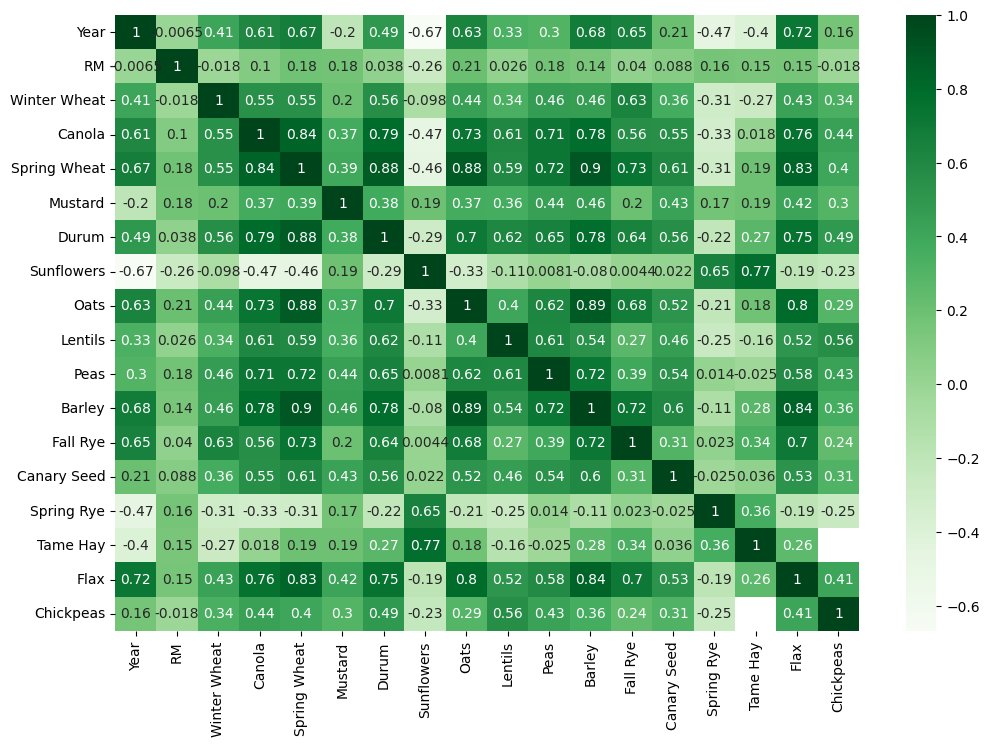

In [525]:
# Heat map to show the relationship between variables - amount of correlation
plt.rcParams['figure.figsize'] = [12, 8]
heatmap = sb.heatmap(ydat[crop_columns].corr(), annot=True, cmap='Greens')

####  Since I am interested in the spring wheat crop yield across Saskatchewan, for simplicity I keep only relevant columns in the dataset for my analyses.

In [385]:
# keep relevant columns in the analysis dataset
ydata = ydat[['Year', 'RM','Spring Wheat']]

In [386]:
ydata.agg(['mean','std'])

,Year,RM,Spring Wheat
mean,1979.882585,248.938172,26.008196
std,24.510677,148.822634,11.415548


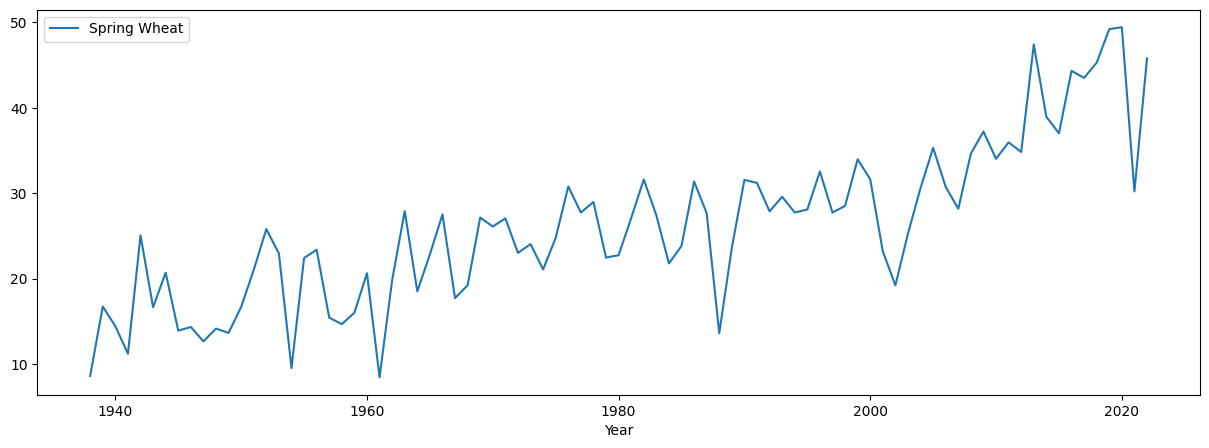

In [387]:
ydata_year = ydata.drop('RM', axis = 1)

# Plot yearly spring wheat yield from 1938 to 2022
plot_yearly = ydata_year.groupby('Year').mean().plot(figsize=(15,5))

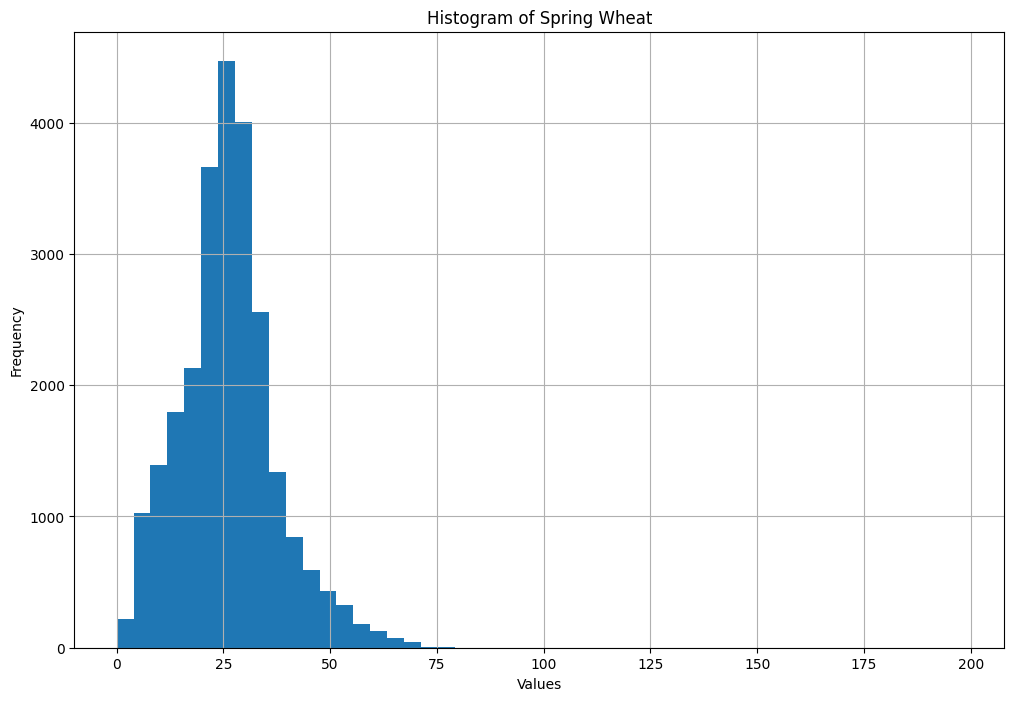

In [388]:
# Plot a histogram of spring wheat yield 
ydata['Spring Wheat'].hist (bins=50)

# Set the title and axis labels
plt.title('Histogram of Spring Wheat')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [389]:
# Check for missing data and outliers
ydata.isna().sum()

Year             0
RM               0
Spring Wheat    99
dtype: int64

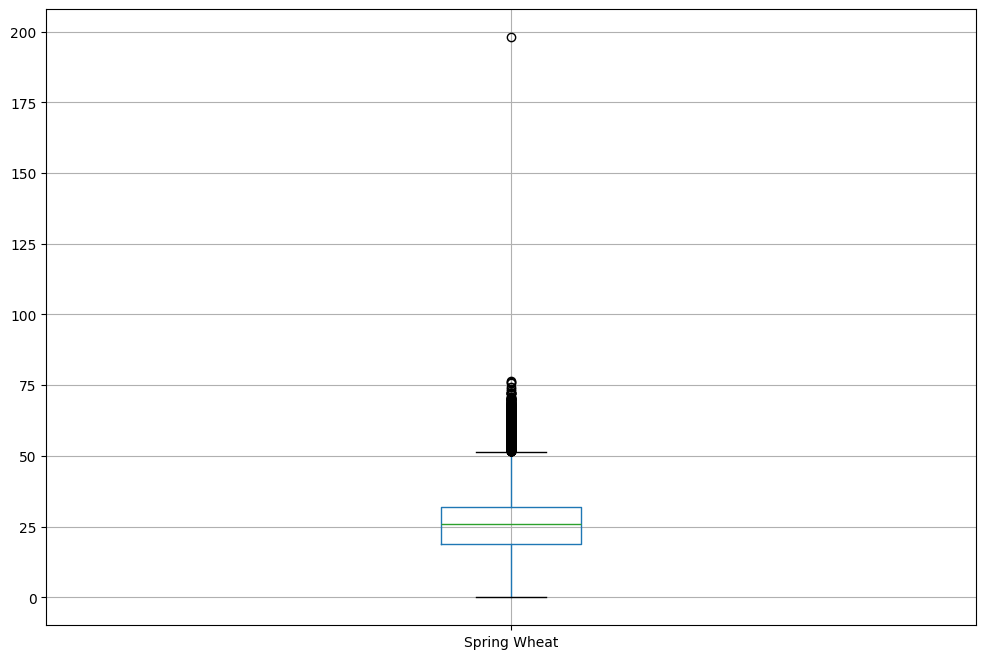

In [390]:
Boxplot =  ydata.boxplot(column=['Spring Wheat']) 

In [391]:
####  There are 99 missing observations and several outliers in the data.

In [392]:
ydata[ydata['Spring Wheat'] == 198]

,Year,RM,Spring Wheat
16215,2018,314,198.0


In [393]:
# check other values in this risk area
ydata[ydata['RM'] == 314].to_csv('RM314.csv')

####  The extreme value for spring wheat yield is 198 in the given dataset and it corresponds to RM 314 in 2018.
####  Values range from 4 to 45 in this RM. If I look at the data from previous years, this data point seems to be a typo.
####  Further investigation is needed to tackle this. For the time being, I will exclude this data point and proceed with the analysis.

In [394]:
ydata = ydata[ydata['Spring Wheat'] != 198]

In [395]:
ydata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25311 entries, 0 to 25311
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25311 non-null  int64  
 1   RM            25311 non-null  int64  
 2   Spring Wheat  25212 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 791.0 KB


In [396]:
ydata.agg(['mean','std'])

,Year,RM,Spring Wheat
mean,1979.881079,248.935601,26.001374
std,24.509990,148.825012,11.364264


In [397]:
# For the outliers from the above boxplot, let's check the yield above 51 
ydata[ydata['Spring Wheat'] > 51 ].to_csv('outliers-yields-SW.csv')

In [398]:
# Explore more into each yield category to see the corresponding RM and Year
y50 = ydata[(ydata['Spring Wheat'] > 50) & (ydata['Spring Wheat'] < 60)]
y60 = ydata[(ydata['Spring Wheat'] >= 60) & (ydata['Spring Wheat'] < 70)]
y70 = ydata[(ydata['Spring Wheat'] >= 70) & (ydata['Spring Wheat'] < 100)]

In [399]:
# see the unique year and RM associated with the yield category
pd.unique(y50[['Year', 'RM']].values.ravel('K'))

array([2019, 2020, 2022, 2014, 2016, 2021, 2017, 2018, 2013, 2009, 2012,
       2005, 2011, 2015, 1999, 2007, 2008,    1,    2,    3,    6,    7,
         31,   32,   33,   34,   35,   36,   46,   61,   63,   64,   65,
         66,   72,   76,   91,   92,   93,   94,   95,   96,   98,  102,
        107,  109,  111,  121,  122,  123,  125,  126,  127,  128,  130,
        136,  151,  152,  153,  154,  155,  156,  157,  158,  159,  160,
        161,  162,  167,  169,  181,  183,  185,  186,  187,  189,  191,
        211,  213,  214,  215,  216,  217,  218,  219,  220,  222,  224,
        225,  226,  229,  241,  243,  244,  245,  246,  247,  248,  251,
        252,  254,  255,  257,  259,  261,  271,  273,  274,  275,  276,
        279,  280,  281,  282,  287,  290,  292,  301,  303,  304,  305,
        307,  308,  309,  310,  312,  315,  316,  318,  319,  322,  331,
        333,  334,  335,  336,  337,  338,  339,  340,  341,  342,  343,
        345,  346,  347,  349,  350,  351,  352,  3

In [400]:
pd.unique(y60[['Year', 'RM']].values.ravel('K'))

array([2016, 2020, 2018, 2013, 2017, 2019, 2022, 2012,   72,   91,   92,
         93,   98,  102,  121,  128,  130,  153,  156,  157,  181,  183,
        186,  187,  189,  191,  211,  213,  244,  271,  273,  274,  276,
        301,  303,  304,  305,  308,  309,  310,  331,  333,  334,  336,
        337,  338,  350,  366,  367,  368,  369,  370,  371,  379,  380,
        381,  394,  397,  398,  399,  400,  401,  403,  404,  406,  409,
        410,  426,  427,  428,  429,  430,  431,  434,  438,  439,  440,
        442,  458,  459,  460,  464,  467,  468,  469,  471,  472,  486,
        487,  491,  493,  494,  496,  497,  498,  499,  501,  502,  520,
        555,  561,  588,  622])

In [401]:
pd.unique(y70[['Year', 'RM']].values.ravel('K'))

array([2022, 2018, 2013, 2019, 2020, 2014,  100,  271,  279,  309,  338,
        368,  369,  399,  439,  464,  499,  555])

In [402]:
#### These values do not look like an outlier to me. Probably a high yield in those areas during that time.
####  It would be great if I could do some research around this time to see what happened in those RMs. 
####  I will keep all these values for my analysis.

In [403]:
# Drop rows with missing values
ycomplete = ydata.dropna()

In [404]:
ycomplete.isna().sum()

Year            0
RM              0
Spring Wheat    0
dtype: int64

In [405]:
# Impute missing values for spring wheat yield

# Calculate the mean of the column
mean_value = ydata['Spring Wheat'].mean()

# Fill missing values with the mean
ydata['Spring Wheat'].fillna(mean_value, inplace=True)

In [406]:
# Get the dimensions of imputed yeild data
ydata.shape

(25311, 3)

In [407]:
# Get the dimensions of yeild data - complete case
ycomplete.shape

(25212, 3)

### Sensitivity Analysis

In [409]:
# Calculate descriptive statistics for columns in each dataset
statistics1 = ydata['Spring Wheat'].describe()
statistics2 = ycomplete['Spring Wheat'].describe()

# Combine the statistics into one DataFrame
combined_statistics = pd.concat([statistics1, statistics2], axis=1)
combined_statistics.columns = ['Imputed Dataset', 'Complete Dataset']

# Print the combined statistics
print(combined_statistics)

       Imputed Dataset  Complete Dataset
count     25311.000000      25212.000000
mean         26.001374         26.001374
std          11.342017         11.364264
min           0.000000          0.000000
25%          19.000000         19.000000
50%          25.900000         25.800000
75%          32.000000         32.000000
max          76.600000         76.600000


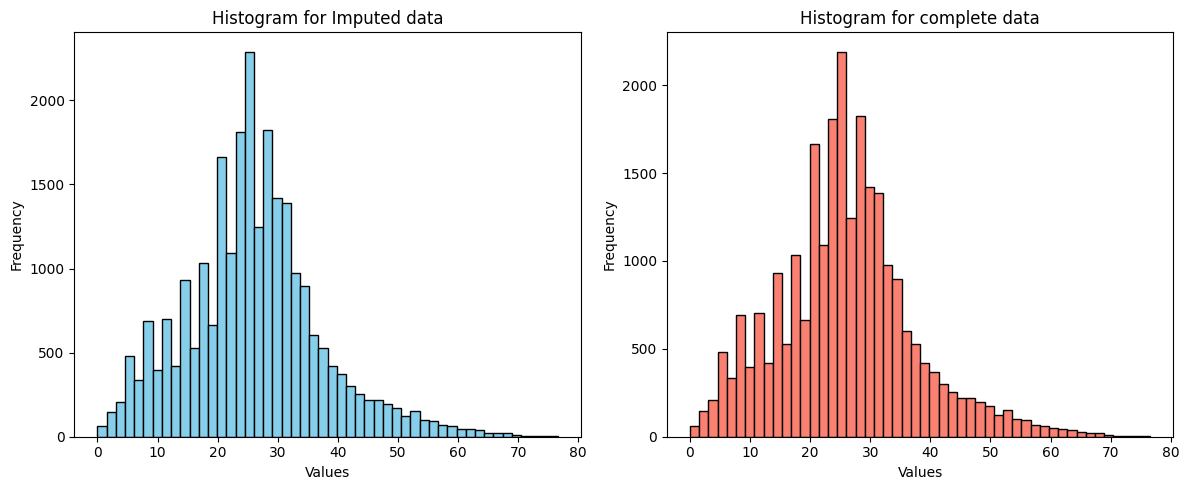

In [450]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(12, 5))

# Plot the first histogram
plt.subplot(1, 2, 1)
plt.hist(ydata['Spring Wheat'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram for Imputed data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Plot the second histogram
plt.subplot(1, 2, 2)
plt.hist(ycomplete['Spring Wheat'], bins=50, color='salmon', edgecolor='black')
plt.title('Histogram for complete data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

#### Both distributions look similar

In [412]:
# Find the number of unique rows based on 'RM'
ydata['RM'].nunique()

299

#### Aggregate spring wheat yield data

In [413]:
# calculate mean of spring wheat yield for each RM
sw_mean = ydata.groupby('RM').mean().reset_index().replace(0,0.000000000001)

# calculate standard deviation of spring wheat yield by RM
sw_std = ydata.groupby('RM').std().reset_index()


mean_sw = pd.DataFrame(sw_mean['Spring Wheat']).add_suffix('_mean')
std_sw = pd.DataFrame(sw_std['Spring Wheat']).add_suffix('_std')

# Aggregate spring wheat yield data
yagg = pd.concat([sw_mean[['RM']], mean_sw, std_sw], axis=1, sort=False)
yagg

,RM,Spring Wheat_mean,Spring Wheat_std
0,1,24.508134,10.963496
1,2,25.928840,10.603374
2,3,25.780588,10.408494
3,4,23.260118,10.193781
4,5,21.607294,9.687136
...,...,...,...
294,529,17.770396,8.035717
295,555,24.880603,12.729146
296,561,27.976049,13.102398
297,588,30.608353,11.052655


In [414]:
yagg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RM                 299 non-null    int64  
 1   Spring Wheat_mean  299 non-null    float64
 2   Spring Wheat_std   299 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.1 KB


#### Kmean Clustering Analysis - aims to partition the spring wheat yield data into k clusters, minimizing within-cluster variability.

In [415]:
# KMean clustering analysis with risk area, mean, and standard deviation of spring wheat yield 
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM = KMeans(n_clusters=n, init='k-means++', n_init=10).fit(yagg)
    # data for the elbow method
    clusters_inertia.append(KM.inertia_)    
    silhouette_avg = silhouette_score(yagg, KM.labels_)
    # data for the silhouette score method
    s_scores.append(silhouette_avg) 

/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_spar

In [416]:
#Elbow Method is an empirical method to find the optimal number of clusters for a dataset. 
#Find the average distance of each point in a cluster to its centroid, and represent it in a plot. 
#Pick the value of k, where the average distance falls suddenly.

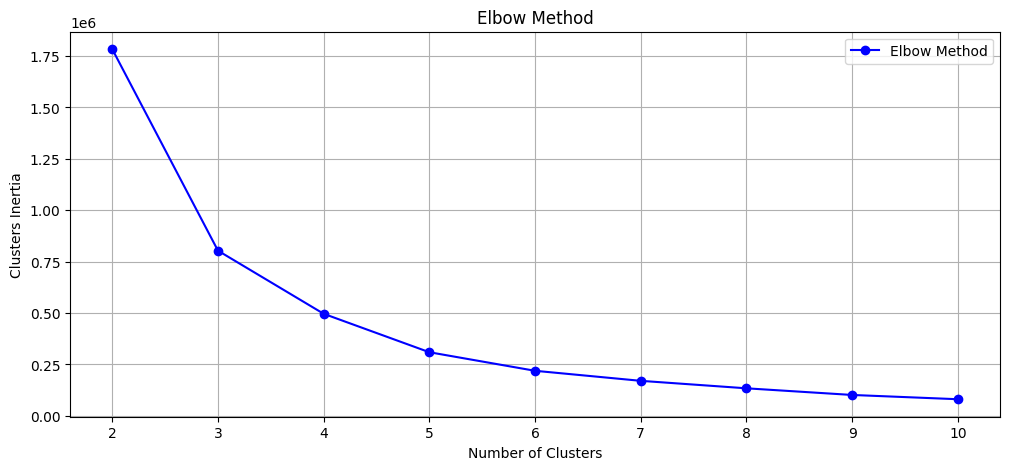

In [417]:
# Elbow Method
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(n_clusters, clusters_inertia, 'o-', color='blue', label='Elbow Method')
ax.set_title("Elbow Method")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Clusters Inertia")
plt.grid()
plt.legend()
plt.show()

In [418]:
# From the above graph, it shows a sudden change for cluster sizes 3 or 4
# Let's consider 3 clusters for the analysis

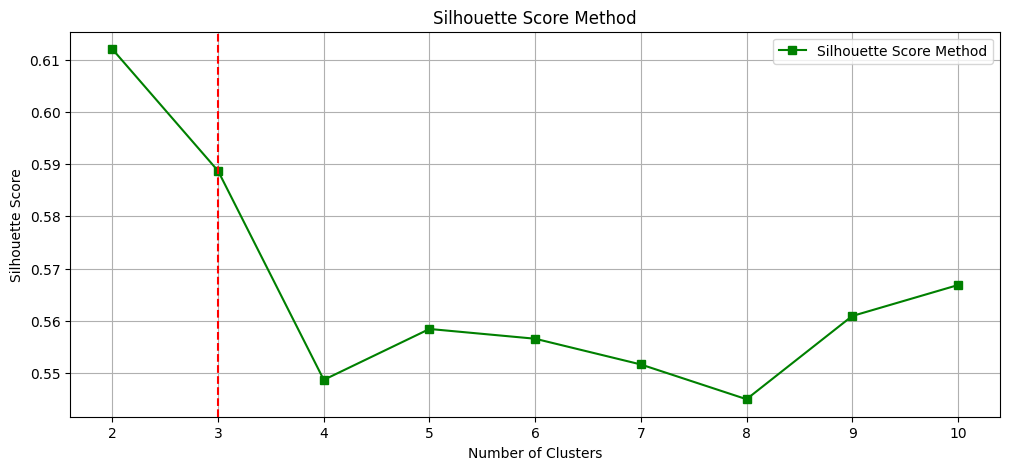

In [419]:
# Verify with Silhouette Score Method
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(n_clusters, s_scores, 's-', color='green', label='Silhouette Score Method')
ax.set_title("Silhouette Score Method")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.axvline(3, ls="--", c="red")
plt.grid()
plt.legend()
plt.show()

In [420]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
yagg['Clusters_3']=kmeans.fit_predict(yagg)

/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/Vineetha/anaconda3/envs/paletteenv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


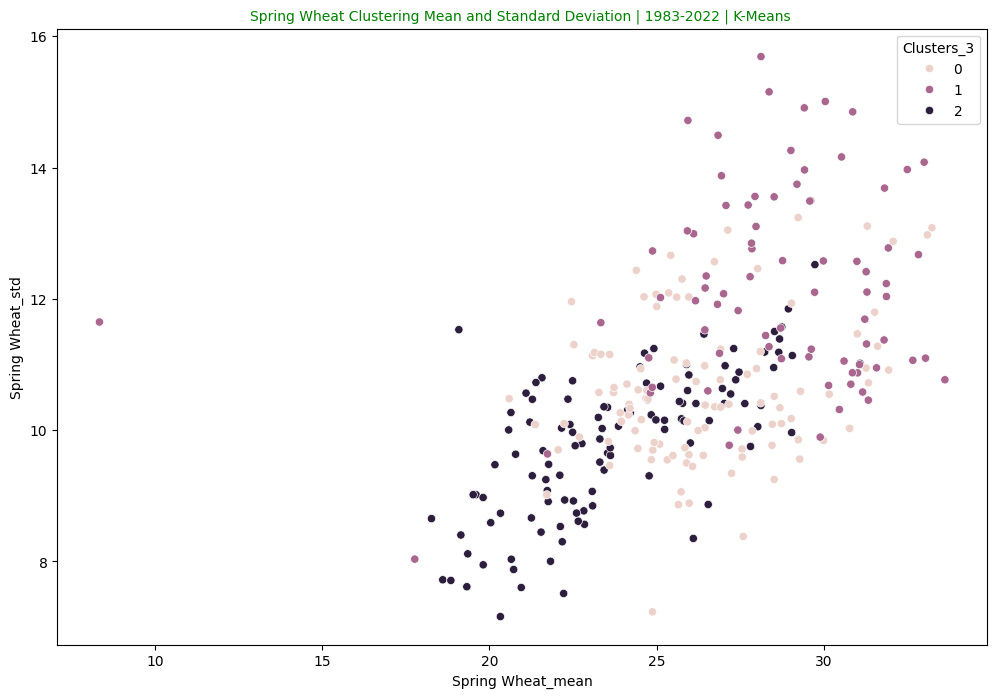

In [421]:
sb.scatterplot(data = yagg, x = 'Spring Wheat_mean', y = 'Spring Wheat_std', hue = 'Clusters_3')
plt.title('Spring Wheat Clustering Mean and Standard Deviation | 1983-2022 | K-Means ', color ='green', size = 10)
plt.show()

#### GIS Analysis

In [422]:
# Read Rural Municipality Shapefiles - Saskatchewan
gdat = gpd.read_file('RuralMunicipality.shp')

In [423]:
gdat.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   PPID        298 non-null    object  
 1   EFFDT       298 non-null    object  
 2   EXPDT       0 non-null      object  
 3   FEATURECD   298 non-null    object  
 4   RMNO        298 non-null    object  
 5   RMNM        298 non-null    object  
 6   SHAPE_AREA  298 non-null    float64 
 7   SHAPE_LEN   298 non-null    float64 
 8   geometry    298 non-null    geometry
dtypes: float64(2), geometry(1), object(6)
memory usage: 21.1+ KB


In [424]:
#  Cordinate Reference Systems (CRS)
gdat['geometry'].crs

<Projected CRS: EPSG:2957>
Name: NAD83(CSRS) / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada between 108°W and 102°W onshore and offshore - Northwest Territories, Nunavut, Saskatchewan.
- bounds: (-108.0, 48.99, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: NAD83 Canadian Spatial Reference System
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [425]:
# Standardazing CRS format
gdat['geometry'] = gdat['geometry'].to_crs('epsg:4326')

In [426]:
# Renaming column name
gdat['RMNO'] = gdat['RMNO'].astype(int)

In [427]:
gdat.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   PPID        298 non-null    object  
 1   EFFDT       298 non-null    object  
 2   EXPDT       0 non-null      object  
 3   FEATURECD   298 non-null    object  
 4   RMNO        298 non-null    int64   
 5   RMNM        298 non-null    object  
 6   SHAPE_AREA  298 non-null    float64 
 7   SHAPE_LEN   298 non-null    float64 
 8   geometry    298 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 21.1+ KB


In [428]:
gdf = pd.concat([gdat[['RMNO','geometry']].rename(columns={'RMNO':'RM'})])

In [429]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   RM        298 non-null    int64   
 1   geometry  298 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 4.8 KB


In [526]:
# gdf.explore() # Commented plot for minimizing file size

In [431]:
# Merge yield data and geo data using SQL inner join
ydata_gdf = pd.merge(gdf, ydata, on = 'RM', how = 'inner') 

In [432]:
ydata_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25125 entries, 0 to 25124
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   RM            25125 non-null  int64   
 1   geometry      25125 non-null  geometry
 2   Year          25125 non-null  int64   
 3   Spring Wheat  25125 non-null  float64 
dtypes: float64(1), geometry(1), int64(2)
memory usage: 785.3 KB


In [433]:
print('Before merging', gdf['RM'].nunique())
print('After merging', ydata_gdf['RM'].nunique())

Before merging 298
After merging 296


In [434]:
gdf['RM'].nunique()

298

In [435]:
ydata['RM'].nunique()

299

In [436]:
ydata_gdf['RM'].nunique()

296

In [437]:
# print(sorted(gdf['RM'].unique()))
# print(sorted(ydata_gdf['RM'].unique()))
# print(sorted(ydata['RM'].unique()))

In [438]:
# Check the RMs that are not in the geo data frame, but are in yield data
df3 = ydata.merge(gdf, how='left', indicator=True)
df4 = df3[df3['_merge'] == 'left_only'][[ 'RM']]
print(sorted(df4['RM'].unique()))

[278, 408, 529]


In [439]:
# Check the RMs that are not in the yield data, but are in the geo data frame
df3 = gdf.merge(ydata, how='left', indicator=True)
df4 = df3[df3['_merge'] == 'left_only'][[ 'RM']]
print(sorted(df4['RM'].unique()))

[998, 999]


In [440]:
# GIS Visualization
# Interactive map 
m = ydata_gdf.loc[ds['Year']==2022].explore(column='Spring Wheat', 
                                 legend=True,  
                                 cmap='Greens',
                                 tooltip= ['Spring Wheat', 'RM'],
                                 tiles='Stamen Toner') 


# Adding a title with a dark orange color to the folium map
title_html = '''
                 <h3 align="center" style="font-size:30px; color:Green;"><b> Spring Wheat Yield in 2022 </b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Save as HTML
m.save('SW_2022.html')

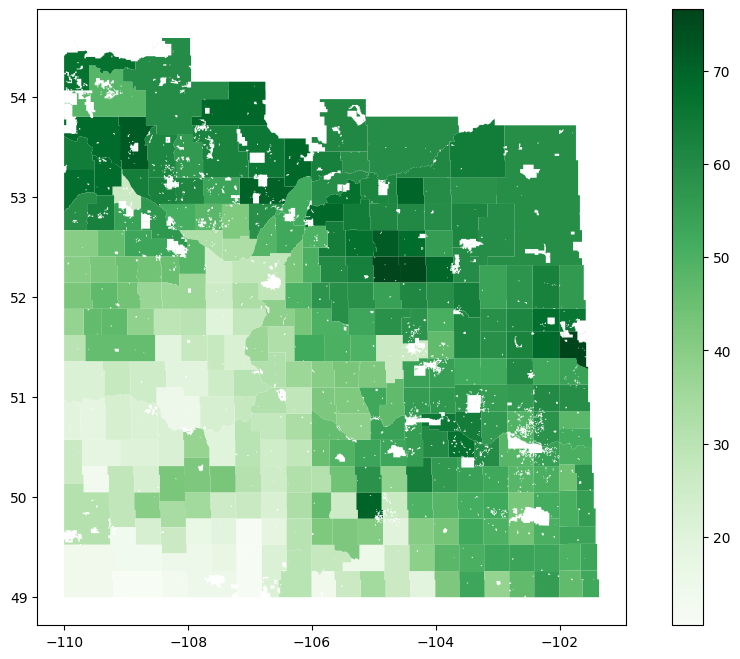

In [441]:
# plotting for GitHub submission - Spring Wheat Yeild
gis_plot = ydata_gdf.loc[ds['Year']==2022].plot(column='Spring Wheat', 
                                 legend=True,  
                                 cmap='Greens')

In [442]:
# Merge aggregate data and see the map with 4 clusters
yagg_gdf = pd.merge(gdf, yagg, on = 'RM', how = 'inner') 

In [443]:
yagg_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   RM                 296 non-null    int64   
 1   geometry           296 non-null    geometry
 2   Spring Wheat_mean  296 non-null    float64 
 3   Spring Wheat_std   296 non-null    float64 
 4   Clusters_3         296 non-null    int32   
dtypes: float64(2), geometry(1), int32(1), int64(1)
memory usage: 10.5 KB


In [527]:
# Interactive map with 3 clusters
# yagg_gdf.explore(column='Clusters_3', legend='True', k = 3, scheme='naturalbreaks', cmap='Oranges')

In [445]:
yagg.groupby('Clusters_3').mean()\
    .sort_values('Spring Wheat_mean')[['Spring Wheat_mean',	'Spring Wheat_std']]

,Spring Wheat_mean,Spring Wheat_std
Clusters_3,,
2,23.766881,9.804834
0,26.365002,10.608673
1,28.536702,12.180403


In [446]:
# Ranking based on the mean
yagg['Clusters_3_ranked_mean'] = yagg['Clusters_3'].replace(to_replace={
    2:0,
    0:1,
    1:2
})

In [528]:
# Interactive map
#pd.merge(gdf, yagg, on='RM').explore(column='Clusters_3_ranked_mean', legend='True', k = 3, scheme='naturalbreaks', cmap='Oranges')
# Commented plot for minimizing file size

In [666]:
# remove geometry column
yagg_gdf1 = yagg_gdf.drop(['geometry'], axis=1)
yagg_gdf1['RM'].dtypes
sorted_results = yagg_gdf1.sort_values(by='RM', ascending=True)
sorted_results.to_csv('Results.csv')

# Findings
#### In line with the objective, the above file (Results.csv) contains information about RM's and the corresponding clusters predicted via Kmean clustering.
#### To be more specific,  clusters of RMs with similar yield and variability are provided. 
#### Spatial patterns of high and low spring wheat yields are displayed in the interactive maps.

# Future Work
#### The analysis could be improved by adding more relevant features other than the mean and standard deviation of the yield data. 
#### Additionally, adding features will help to build prediction models for spring wheat yield.